# Car price prediction 🚗

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.


Требуется построить модель, которая умеет её определять по данным о технических характеристиках, комплектации и ценах автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Содержание**<a id='toc0_'></a>    
1. [Подготовка   ](#toc1_)    
1.1. [Библиотеки                   ](#toc1_1_)    
1.2. [Конфигурация                   ](#toc1_2_)    
1.3. [Сервисные функции                   ](#toc1_3_)    
2. [Данные                   ](#toc2_)    
2.1. [Загрузка                   ](#toc2_1_)    
2.2. [Переименование колонок                   ](#toc2_2_)    
2.3. [Проверка типов данных                  ](#toc2_3_)    
2.4. [Обработка дубликатов                  ](#toc2_4_)    
2.5. [Проверка пропусков                  ](#toc2_5_)    
2.6. [Изучение столбцов                 ](#toc2_6_)    
2.6.1. [Таргет (столбец `price`)                ](#toc2_6_1_)    
2.6.2. [Столбец `date_crawled`                ](#toc2_6_2_)    
2.6.3. [Столбец `vehicle_type`                ](#toc2_6_3_)    
2.6.4. [Столбец `registration_year`                ](#toc2_6_4_)    
2.6.5. [Столбец `gearbox`                ](#toc2_6_5_)    
2.6.6. [Столбец `power`                ](#toc2_6_6_)    
2.6.7. [Столбец `model`               ](#toc2_6_7_)    
2.6.8. [Столбец `kilometer`               ](#toc2_6_8_)    
2.6.9. [Столбец `registration_month`               ](#toc2_6_9_)    
2.6.10. [Столбец `fuel_type`               ](#toc2_6_10_)    
2.6.11. [Столбец `brand`               ](#toc2_6_11_)    
2.6.12. [Столбец `repaired`               ](#toc2_6_12_)    
2.6.13. [Столбец `date_created`               ](#toc2_6_13_)    
2.6.14. [Столбец `number_of_pictures`               ](#toc2_6_14_)    
2.6.15. [Столбец `postal_code`               ](#toc2_6_15_)    
2.6.16. [Столбец `last_seen`               ](#toc2_6_16_)    
2.7. [Выводы по датасету                ](#toc2_7_)    
3. [Корреляция            ](#toc3_)    
3.1. [Корреляция          ](#toc3_1_)    
3.2. [Мультиколлинеарность          ](#toc3_2_)    
3.3. [Выводы по коллинеарности         ](#toc3_3_)    
4. [Оптимизация памяти     ](#toc4_)    
5. [Разделение данных            ](#toc5_)    
6. [Трансформеры и пайплайны          ](#toc6_)    
7. [Модели             ](#toc7_)    
7.1. [`KNeighborsRegressor`        ](#toc7_1_)    
7.2. [`Ridge`        ](#toc7_2_)    
7.3. [`LinearSVR`        ](#toc7_3_)    
7.4. [`RandomForestRegressor`        ](#toc7_4_)    
7.5. [`CatBoostRegressor`        ](#toc7_5_)    
7.6. [`LGBMRegressor`        ](#toc7_6_)    
7.7. [Результаты        ](#toc7_7_)    
7.8. [Метрика на тестовом датасете](#toc7_8_)    
8. [Важность признаков     ](#toc8_)    
9. [Финальный вывод        ](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>Подготовка    [&#8593;](#toc0_)

### 1.1. <a id='toc1_1_'></a>Библиотеки                    [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [2]:
%pip install --upgrade -q numpy
%pip install matplotlib==3.5.2
%pip install --upgrade -q phik
%pip install --upgrade -q shap
%pip install --upgrade -q prettytable
%pip install --upgrade -q termcolor
%pip install --upgrade -q seaborn
%pip install --upgrade -q pandas
%pip install --upgrade -q statsmodels
%pip install --upgrade -q scikit-learn
%pip install --upgrade -q missingno
%pip install --upgrade -q catboost
%pip install --upgrade -q lightgbm

clear_output()

In [3]:
import re
from os.path import exists

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import shap

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.base import (BaseEstimator,
                          TransformerMixin)

# Preprocessing
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder)

# Models
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import (GridSearchCV,
                                     train_test_split)
from sklearn.metrics import root_mean_squared_error
from phik import phik_matrix  # this import IS accessed
from prettytable import PrettyTable
from termcolor import colored
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

### 1.2. <a id='toc1_2_'></a>Конфигурация                    [&#8593;](#toc0_)

In [4]:
RANDOM_STATE = 27
TEST_SIZE = 0.20

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

### 1.3. <a id='toc1_3_'></a>Сервисные функции                    [&#8593;](#toc0_)

In [5]:
def get_dataframe(paths: list[str], **kwargs) -> pd.DataFrame:
    for _path in paths:
        if not exists(_path) and not _path.startswith('http'):
            continue

        try:
            df = pd.read_csv(_path, **kwargs)
        except:
            continue

        if df is None:
            continue

        return df

    raise FileNotFoundError('No paths are valid and/or for correct csv file.')

In [6]:
def pascal_to_snake(s: str) -> str:
    # Добавляем подчеркивание перед каждой заглавной буквой, кроме первой
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', s)

    # Добавляем подчеркивание перед заглавными буквами, если они следуют за строчными
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [7]:
def print_table_about_nans(data: pd.DataFrame) -> None:
    table = PrettyTable()
    table.field_names = ['Feature', 'Missing values count']

    missing_info = data.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'green' if count == 0 else 'red'
        s = f'{count} ({count / len(data):.2%})'
        table.add_row([col, colored(s, color)])

    print(table)

In [8]:
def get_info_about_nan_in_series(series: pd.Series) -> None:
    nan_cnt = series.isna().sum()
    text = colored('No missing values', 'green') if nan_cnt == 0 \
        else colored(f'{nan_cnt} ({nan_cnt / len(series):.2%})', 'red')
    print(text)

In [9]:
def draw_plots_about_column(df: pd.DataFrame,
                            column: str,
                            column_description: str = None,
                            bins: int = 20
                            ) -> None:
    if column_description is None:
        column_description = column

    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    sns.violinplot(df, x=column, ax=ax1, orient='h')
    ax1.set_xlabel(column_description)
    ax1.grid()

    sns.boxplot(df, x=column, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()

    sns.histplot(df, x=column, bins=bins, ax=ax3)
    ax3.set_xlabel(column_description)
    ax3.grid()
    ax3.set_ylabel('Количество')

    ax4.set_visible(False)

    plt.suptitle(f'Информация о колонке `{column_description}`', fontsize=18)
    plt.tight_layout()

    plt.show()

In [ ]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    """Function optimizes memory usage in dataframe

    Args:
        df (pd.DataFrame): DataFrame to optimize.
        print_size (bool, optional): display of optimization results. Defaults to True.

    Returns:
        pd.DataFrame: optimized DataFrame
    """

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)

    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size:
        print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                            .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [11]:
def get_plots_about_residuals(y_true: np.array, y_pred: np.array) -> None:
    res = y_true - y_pred

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    sns.histplot(res, ax=ax1)
    ax1.set_xlabel('Остатки')
    ax1.set_ylabel('Количество')
    ax1.axvline(x=0, color='green', lw=3, ls='-', label='Нулевое значение')
    ax1.axvline(x=res.mean(), color='red', lw=3, ls='--', label='Среднее значение остатков')
    ax1.legend()

    sns.scatterplot(x=y_pred, y=res, ax=ax2)
    ax2.set_xlabel('Предсказанные значение')
    ax2.set_ylabel('Остатки')

    fig.suptitle('Информация об остатках')

## 2. <a id='toc2_'></a>Данные                    [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Загрузка                    [&#8593;](#toc0_)

In [12]:
df = get_dataframe([
    './data/autos.csv',
    '/datasets/autos.csv',
    'https://code.s3.yandex.net/datasets/autos.csv'
], parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [13]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


### 2.2. <a id='toc2_2_'></a>Переименование колонок                    [&#8593;](#toc0_)

In [14]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Названия признаков не соответствует PEP8, поэтому переименуем их.

In [15]:
df.columns = [pascal_to_snake(col) for col in df.columns]

In [16]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### 2.3. <a id='toc2_3_'></a>Проверка типов данных                   [&#8593;](#toc0_)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

Все столбцы имеют верные типы данных.

### 2.4. <a id='toc2_4_'></a>Обработка дубликатов                   [&#8593;](#toc0_)

In [18]:
df.duplicated().sum()

4

Обнаружены 4 полных дубликата. Удалим их.

In [19]:
df = df.drop_duplicates()

In [20]:
df.duplicated().sum()

0

### 2.5. <a id='toc2_5_'></a>Проверка пропусков                   [&#8593;](#toc0_)

In [21]:
print_table_about_nans(df)

+--------------------+----------------------+
|      Feature       | Missing values count |
+--------------------+----------------------+
|    date_crawled    |      0 (0.00%)       |
|       price        |      0 (0.00%)       |
| registration_year  |      0 (0.00%)       |
|       power        |      0 (0.00%)       |
|     kilometer      |      0 (0.00%)       |
| registration_month |      0 (0.00%)       |
|       brand        |      0 (0.00%)       |
|    date_created    |      0 (0.00%)       |
| number_of_pictures |      0 (0.00%)       |
|    postal_code     |      0 (0.00%)       |
|     last_seen      |      0 (0.00%)       |
|       model        |    19705 (5.56%)     |
|      gearbox       |    19833 (5.60%)     |
|     fuel_type      |    32895 (9.28%)     |
|    vehicle_type    |    37490 (10.58%)    |
|      repaired      |    71154 (20.08%)    |
+--------------------+----------------------+


Как мы видим, бóльшая часть признаков (11 из 16 колонок) не имеют пропусков. А оставшиеся 5 имеют от `5%` до `20%` пропущенных значений. Изучим пропуски дополнительно.

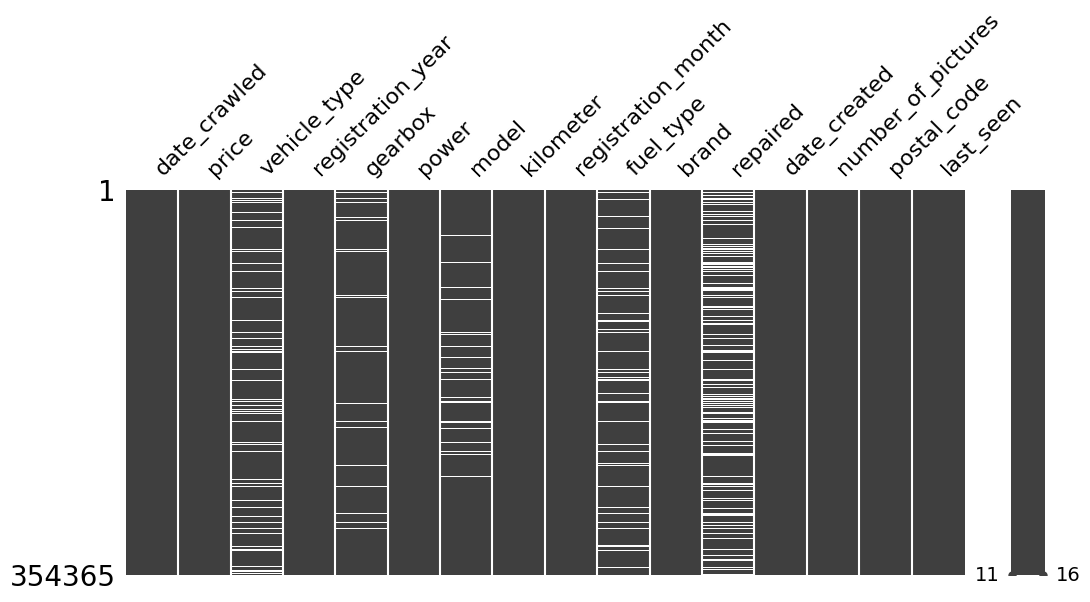

In [22]:
msno.matrix(df, figsize=(12, 5));

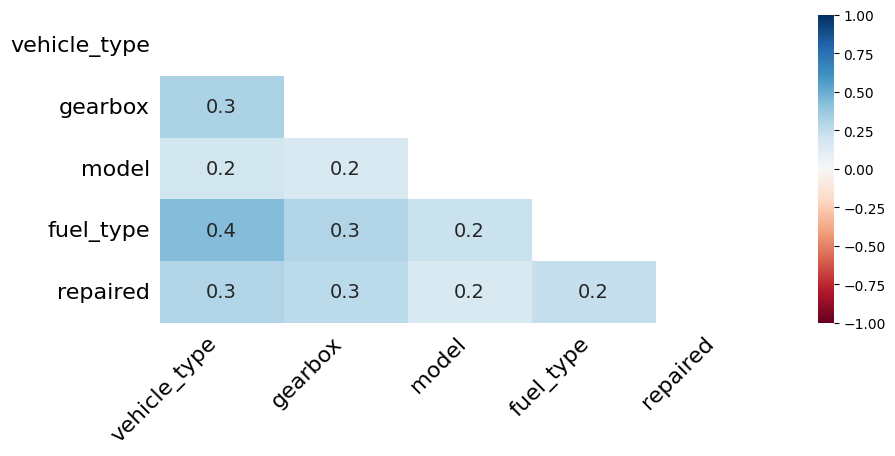

In [23]:
msno.heatmap(df, figsize=(10, 4));

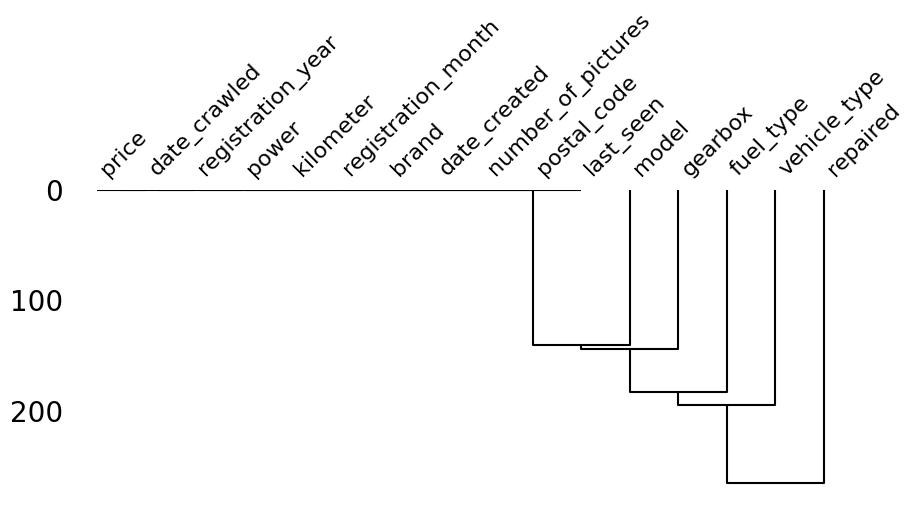

In [24]:
msno.dendrogram(df, figsize=(10, 4));

Как мы видим, корреляция среди пропусков практически не наблюдается.

Заполнение пропусков будет выполнено в пайплайне.

### 2.6. <a id='toc2_6_'></a>Изучение столбцов                  [&#8593;](#toc0_)

In [25]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

**Признаки:**  
`date_crawled` — дата скачивания анкеты из базы  
`vehicle_type` — тип автомобильного кузова  
`registration_year` — год регистрации автомобиля  
`gearbox` — тип коробки передач  
`power` — мощность (л. с.)  
`model` — модель автомобиля  
`kilometer` — пробег (км)  
`registration_month` — месяц регистрации автомобиля  
`fuel_type` — тип топлива  
`brand` — марка автомобиля  
`repaired` — была машина в ремонте или нет  
`date_created` — дата создания анкеты  
`number_of_pictures` — количество фотографий автомобиля  
`postal_code` — почтовый индекс владельца анкеты (пользователя)  
`last_seen` — дата последней активности пользователя  

**Целевой признак:**  
`price` — цена (евро)

#### 2.6.1. <a id='toc2_6_1_'></a>Таргет (столбец `price`)                 [&#8593;](#toc0_)

In [26]:
get_info_about_nan_in_series(df['price'])

No missing values


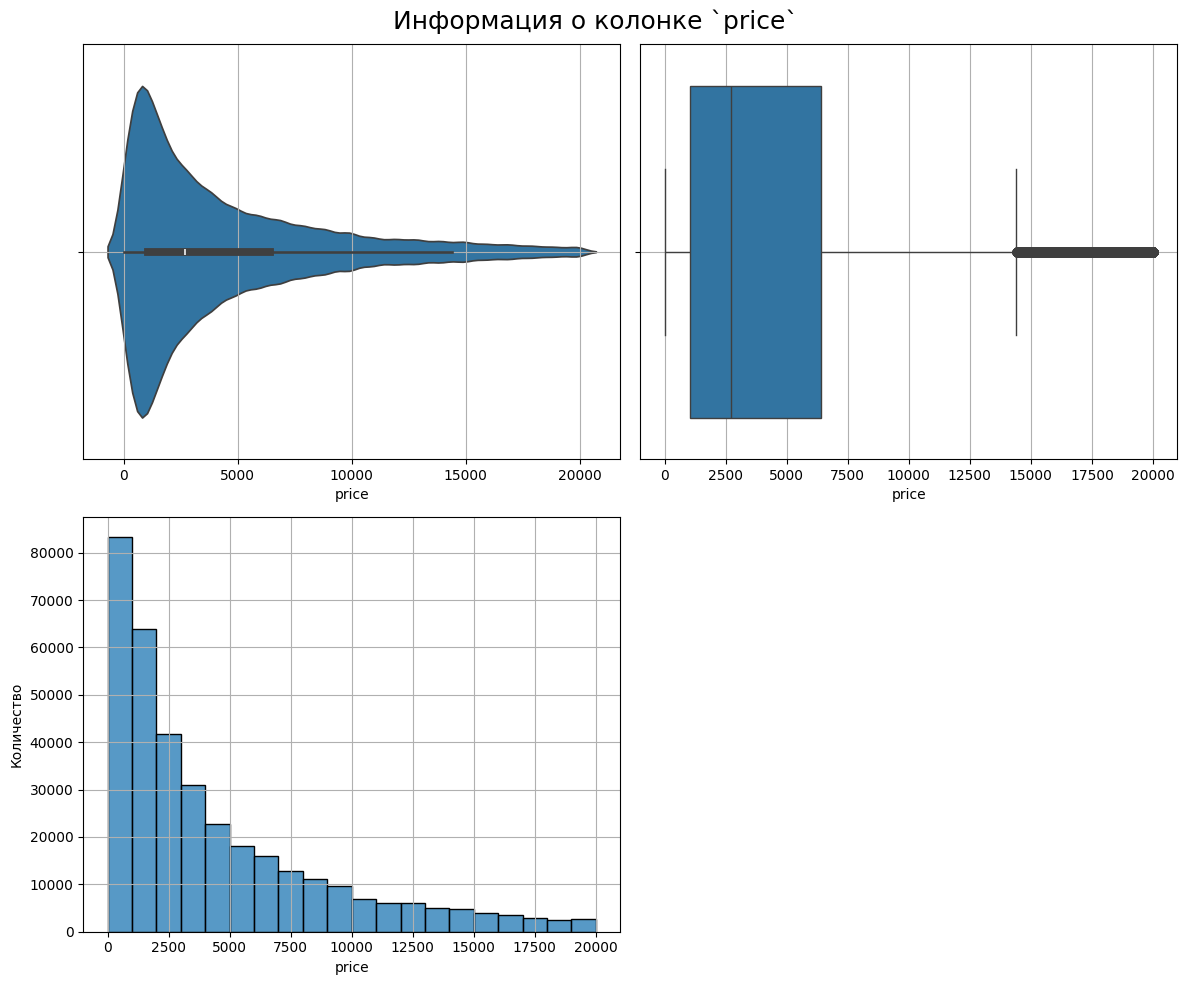

In [27]:
draw_plots_about_column(df, 'price')

In [28]:
mask = df['price'] == 0
mask.sum(), f'{mask.sum() / len(df):.2%}'

(10772, '3.04%')

В датасете есть `10_772` записи (чуть больше `3%`) с ценой равной `0`. В целом, они могут отражать некую тенденцию. Например, владелец отдает авто бесплатно, так машина после аварии и так далее. Однако в рамках поставленной задачи эти данные не актуальны. Поэтому удалим их.

In [29]:
len_before = len(df)
df = df[~mask]
assert len_before - len(df) == mask.sum(), 'Удалено слишком много/мало строк'

#### 2.6.2. <a id='toc2_6_2_'></a>Столбец `date_crawled`                 [&#8593;](#toc0_)

In [30]:
get_info_about_nan_in_series(df['date_crawled'])

No missing values


In [31]:
df['date_crawled'].describe()

count                           343593
mean     2016-03-21 12:55:04.584723968
min                2016-03-05 14:06:22
25%                2016-03-13 11:49:14
50%                2016-03-21 17:49:25
75%                2016-03-29 14:38:32
max                2016-04-07 14:36:58
Name: date_crawled, dtype: object

Все даты адекватны.

#### 2.6.3. <a id='toc2_6_3_'></a>Столбец `vehicle_type`                 [&#8593;](#toc0_)

In [32]:
get_info_about_nan_in_series(df['vehicle_type'])

33750 (9.82%)


Данный столбец имеет почти `10%` пропущенных значений.

In [33]:
df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [34]:
df['vehicle_type'].value_counts()

vehicle_type
sedan          89405
small          78017
wagon          63700
bus            28345
convertible    19865
coupe          15634
suv            11791
other           3086
Name: count, dtype: int64

Предположим, что если пользователь не указал тип, но его не было в списке. Поэтому отнесем все строки с пропущенным значением к категории `other`.

#### 2.6.4. <a id='toc2_6_4_'></a>Столбец `registration_year`                 [&#8593;](#toc0_)

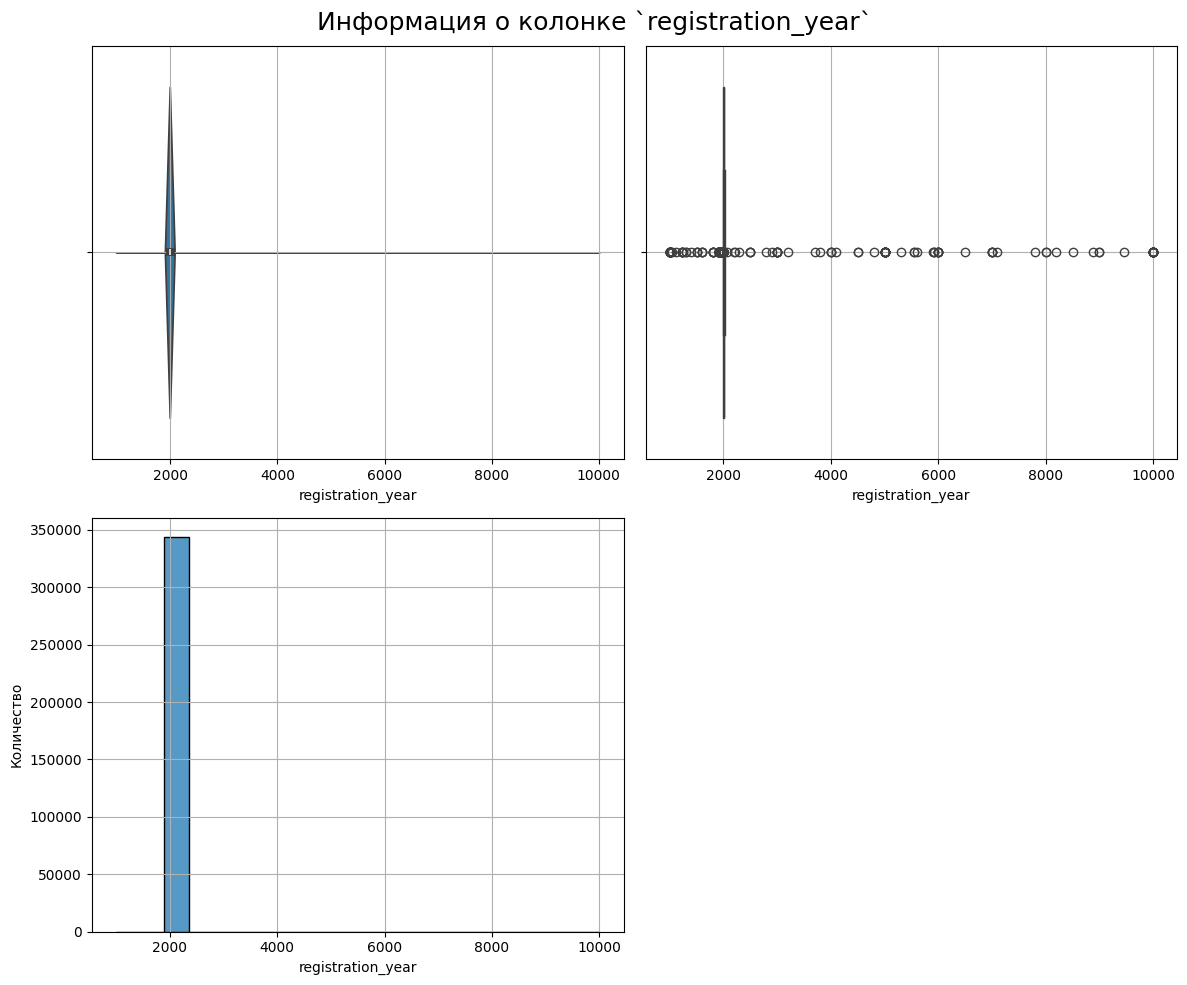

In [35]:
draw_plots_about_column(df, 'registration_year')

Видим, что есть записи, где год регистрации автомобиля сильно больше или меньше допустимых. Данные были выгружены в 2016 году. Значит все года после этого - аномалии. Также наша задача предсказывать цены на "обычные", современные автомобили, а не раритет. Поэтому ограничим снизу 1960 годом. И изучим дополнительно.

In [36]:
mask = (df['registration_year'] > 2016) |(df['registration_year'] < 1960)
mask.sum(), f'{mask.sum() / len(df):.2%}'

(14119, '4.11%')

In [37]:
df[mask].sample(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
254768,2016-03-30 22:39:18,2700,NaN,2017,manual,60,fiesta,125000,7,petrol,ford,no,2016-03-30,0,22962,2016-04-05 13:16:01
159464,2016-03-23 14:38:43,1100,NaN,2017,manual,0,a_klasse,150000,5,gasoline,mercedes_benz,NaN,2016-03-23,0,47179,2016-03-24 21:48:19
223184,2016-03-20 11:51:02,2400,NaN,2017,manual,60,corsa,80000,6,petrol,opel,yes,2016-03-20,0,12279,2016-04-06 10:16:25
9671,2016-03-25 15:54:44,2275,NaN,2017,NaN,0,3er,150000,3,NaN,bmw,NaN,2016-03-25,0,26129,2016-04-06 20:16:48
305154,2016-03-23 18:36:44,500,NaN,2017,manual,50,polo,150000,10,petrol,volkswagen,NaN,2016-03-23,0,10319,2016-03-26 12:47:00


Действительно, обнаружено более `14_000` записей, где указан невозможный год регистрации. Эти данные составляют чуть более `4%`, удалим их.

In [38]:
len_before = len(df)
df = df[~mask]
assert len_before - len(df) == mask.sum(), 'Удалено слишком много/слишком мало строк'

Посмотрим еще раз на распределение данных:

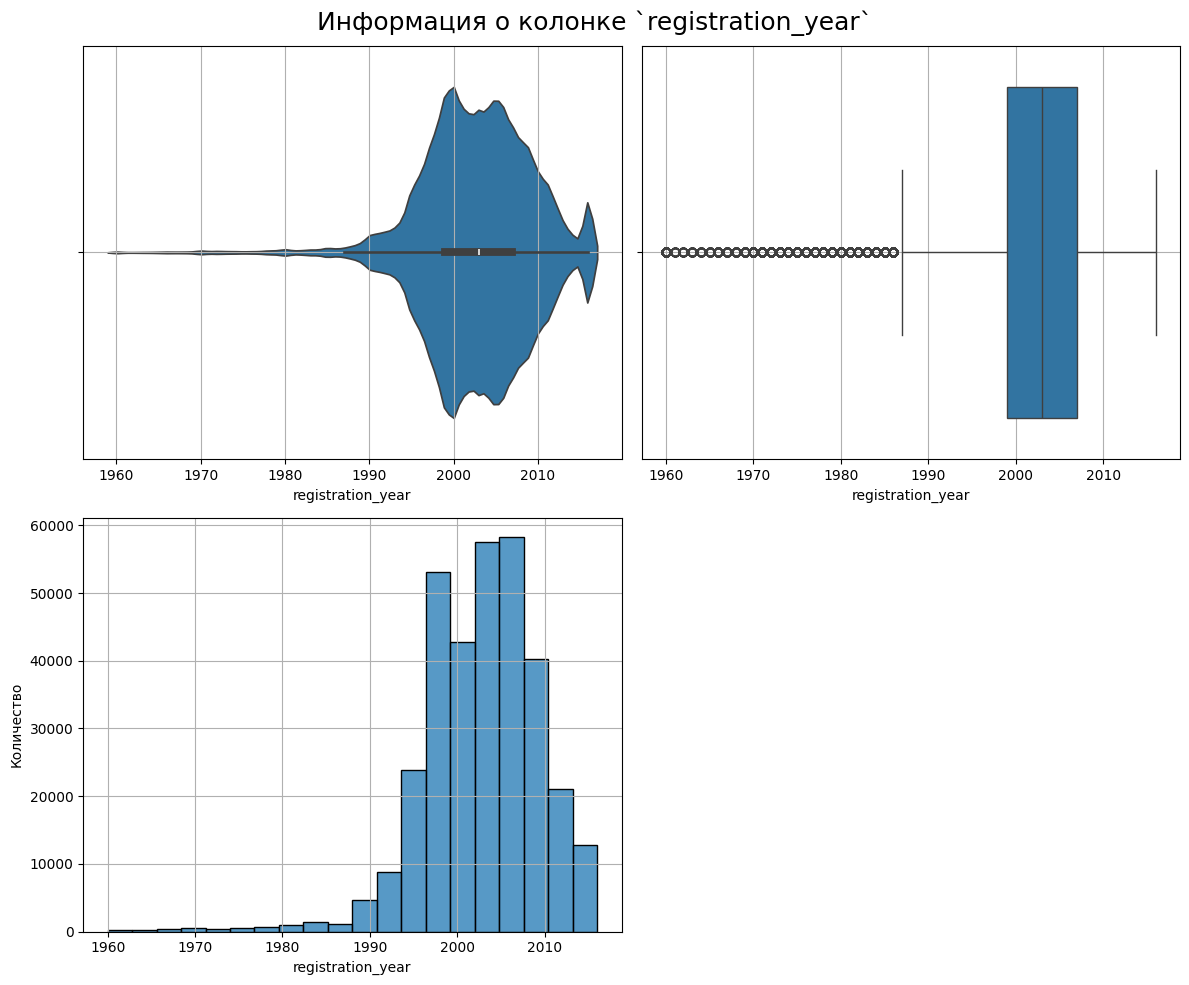

In [39]:
draw_plots_about_column(df, 'registration_year')

Теперь ситуация выглядит более реалистичной.

#### 2.6.5. <a id='toc2_6_5_'></a>Столбец `gearbox`                 [&#8593;](#toc0_)

In [40]:
get_info_about_nan_in_series(df['gearbox'])

15517 (4.71%)


In [41]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [42]:
df['gearbox'].value_counts()

gearbox
manual    250975
auto       62982
Name: count, dtype: int64

Почти `5%` пропусков. Однозначно восстановить это практически невозможно. Можно, конечно заполнить пропуски на основе информации о модели. Однако такое сложное заполнение не требуется в рамках данного проекта. Поэтому заполним пропуски специальной категорией `unknown` (*заполнение будет в пайплайне*).

#### 2.6.6. <a id='toc2_6_6_'></a>Столбец `power`                 [&#8593;](#toc0_)

In [43]:
get_info_about_nan_in_series(df['power'])

No missing values


In [44]:
df['power'].describe()

count   329474.00
mean       111.96
std        184.88
min          0.00
25%         71.00
50%        105.00
75%        143.00
max      20000.00
Name: power, dtype: float64

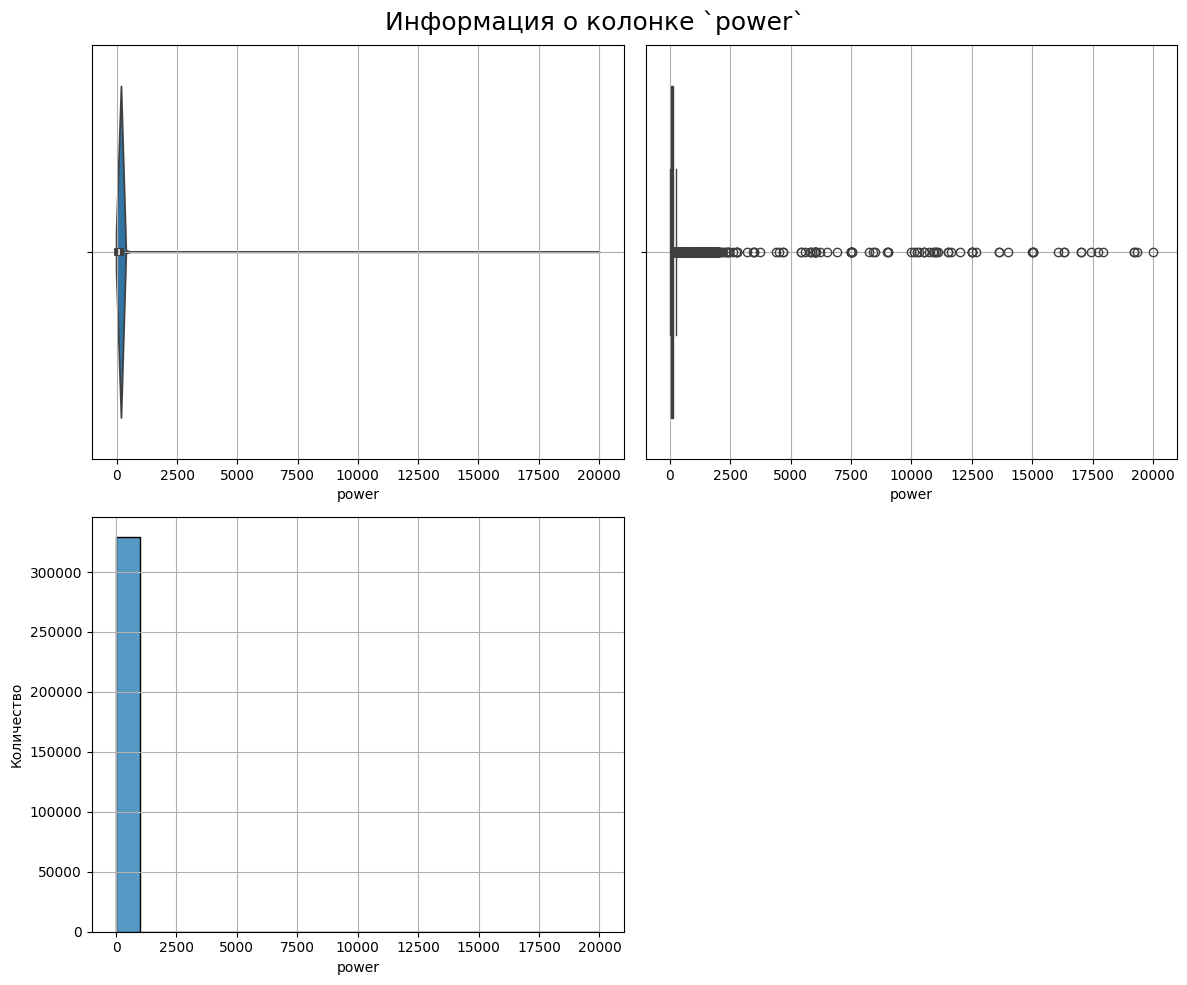

In [45]:
draw_plots_about_column(df, 'power')

In [46]:
mask = df['power'] == 0
mask.sum(), f'{mask.sum() / len(df):.2%}'

(32731, '9.93%')

`32731` записей (почти `10%`) об автомобилях с `0` лошадинных сил. Скорее всего это несет в себе какую-то информацию, например, что автомобиль продается без двигателя. Однако опять же в рамках данного проекта, это аномалии. Поэтому удалим их.

In [47]:
len_before = len(df)
df = df[~mask]
assert len_before - len(df) == mask.sum(), 'Удалено слишком много/мало строк'

Большая часть машин имеет не более `150` лошадиных сил, однако встречаются уникальные машины вплоть до `20_000` лошадиных сил. Данные значения являются выбросами, но вполне реальны для крупных промышленных моделей или гоночных вариантов.

#### 2.6.7. <a id='toc2_6_7_'></a>Столбец `model`                [&#8593;](#toc0_)

In [48]:
get_info_about_nan_in_series(df['model'])

11184 (3.77%)


In [49]:
df['model'].nunique()

249

In [50]:
df['model'].value_counts()

model
golf                  24743
other                 20396
3er                   17402
polo                  10707
corsa                 10144
                      ...  
serie_2                   5
kalina                    5
serie_3                   3
range_rover_evoque        2
rangerover                2
Name: count, Length: 249, dtype: int64

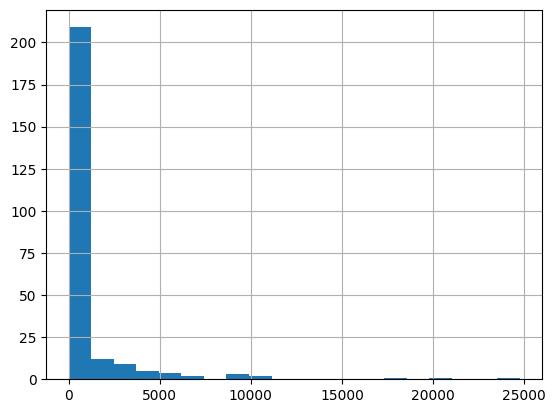

In [51]:
df['model'].value_counts().hist(bins=20);

Почти `4%` пропусков. Самым разумным будет заполнить категорией `other`. Также заметим, что бóльшая часть категорий довольно редкие при большом количестве (`249` уникальных категорий). Учтем это при кодировании.

#### 2.6.8. <a id='toc2_6_8_'></a>Столбец `kilometer`                [&#8593;](#toc0_)

In [52]:
get_info_about_nan_in_series(df['kilometer'])

No missing values


In [53]:
df['kilometer'].describe()

count   296743.00
mean    128289.78
std      36780.06
min       5000.00
25%     125000.00
50%     150000.00
75%     150000.00
max     150000.00
Name: kilometer, dtype: float64

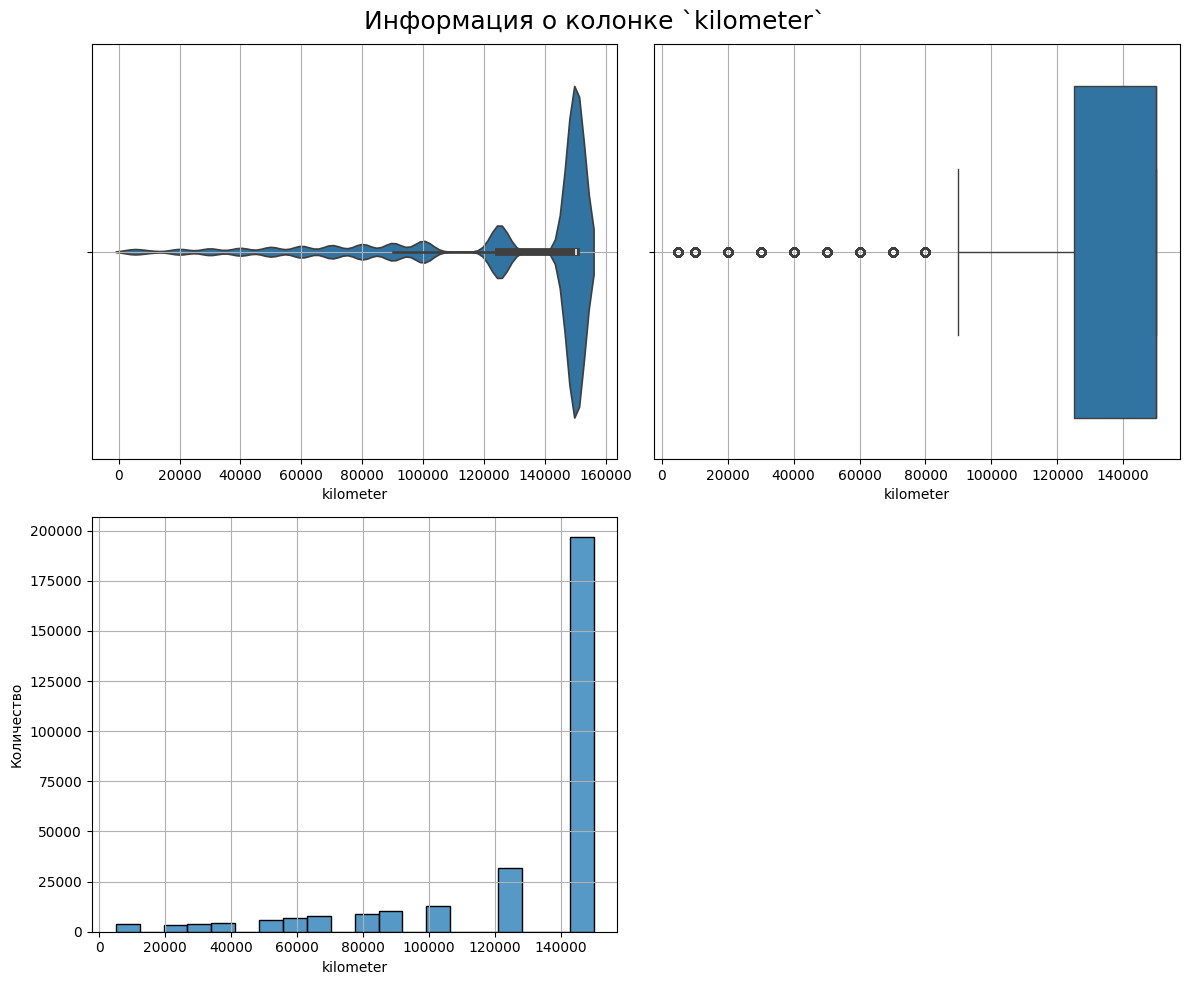

In [54]:
draw_plots_about_column(df, 'kilometer')

#### 2.6.9. <a id='toc2_6_9_'></a>Столбец `registration_month`                [&#8593;](#toc0_)

In [55]:
get_info_about_nan_in_series(df['registration_month'])

No missing values


In [56]:
df['registration_month'].describe()

count   296743.00
mean         5.99
std          3.58
min          0.00
25%          3.00
50%          6.00
75%          9.00
max         12.00
Name: registration_month, dtype: float64

In [57]:
df['registration_month'].nunique()

13

In [58]:
df['registration_month'].value_counts()

registration_month
3     30478
6     27634
4     25816
5     25681
7     23868
10    23004
12    21279
11    21092
9     21007
1     20223
8     19764
2     18889
0     18008
Name: count, dtype: int64

Видно, что есть 13 уникальных значений. Это несколько странно: есть и 0 месяц и 12. А одновременно это невозможно. Скорее всего значение `0` это некая "заглушка", которая несет в себе информацию. Например, что владелей авто не помнит месяц регистрации. Поэтому оставим данный столбец без изменений.

#### 2.6.10. <a id='toc2_6_10_'></a>Столбец `fuel_type`                [&#8593;](#toc0_)

In [59]:
get_info_about_nan_in_series(df['fuel_type'])

15623 (5.26%)


In [60]:
df['fuel_type'].value_counts()

fuel_type
petrol      187658
gasoline     87915
lpg           4690
cng            485
hybrid         202
other           94
electric        76
Name: count, dtype: int64

- Видим `8%` пропусков. Заполним их в пайплайне. 
- Значения `petrol` и `gasoline` по сути обозначают одно и тоже. Произведем замену в соответствующем трансформере в пайплайне.
- Также заметим, что довольно много категорий встречаются редко. Имеет смысл объединить их всех, чтобы не усложнять модель. Проделаем эти шаги в пайплайне.

#### 2.6.11. <a id='toc2_6_11_'></a>Столбец `brand`                [&#8593;](#toc0_)

In [61]:
get_info_about_nan_in_series(df['brand'])

No missing values


In [62]:
df['brand'].nunique()

40

In [63]:
df['brand'].value_counts()

brand
volkswagen        64173
opel              32571
bmw               32306
mercedes_benz     27364
audi              25660
ford              20738
renault           13963
peugeot            9424
fiat               7689
seat               5864
skoda              4950
mazda              4728
smart              4490
citroen            4258
nissan             4053
toyota             4018
hyundai            3110
mini               2968
volvo              2825
mitsubishi         2502
honda              2367
kia                2090
alfa_romeo         1980
suzuki             1966
sonstige_autos     1806
chevrolet          1462
chrysler           1167
dacia               801
subaru              648
porsche             626
daihatsu            616
jeep                570
saab                474
land_rover          465
jaguar              440
daewoo              412
lancia              386
rover               367
trabant             289
lada                157
Name: count, dtype: int64

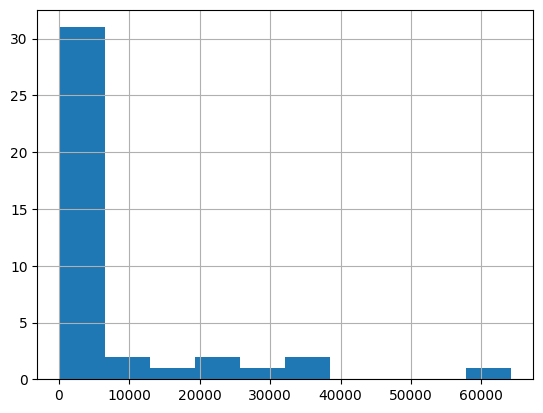

In [64]:
df['brand'].value_counts().hist();

Видим `40` категорий, из которых часть встречает довольно редко. Учтем это при кодировании.

#### 2.6.12. <a id='toc2_6_12_'></a>Столбец `repaired`                [&#8593;](#toc0_)

In [65]:
get_info_about_nan_in_series(df['repaired'])

43027 (14.50%)


In [66]:
df['repaired'].value_counts()

repaired
no     224745
yes     28971
Name: count, dtype: int64

Однозначно восстановить этот признак невозможно. При этом он является довольно важным. Поэтому заполним пропуски отдельной категорией `unknown`.

#### 2.6.13. <a id='toc2_6_13_'></a>Столбец `date_created`                [&#8593;](#toc0_)

In [67]:
get_info_about_nan_in_series(df['date_created'])

No missing values


In [68]:
df['date_created'].describe()

count                           296743
mean     2016-03-20 19:19:58.552282624
min                2015-03-20 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: date_created, dtype: object

In [69]:
mask = df['date_created'] >= df['date_crawled']
mask.sum()

0

#### 2.6.14. <a id='toc2_6_14_'></a>Столбец `number_of_pictures`                [&#8593;](#toc0_)

In [70]:
get_info_about_nan_in_series(df['number_of_pictures'])

No missing values


In [71]:
df['number_of_pictures'].describe()

count   296743.00
mean         0.00
std          0.00
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          0.00
Name: number_of_pictures, dtype: float64

In [72]:
df['number_of_pictures'].unique()

array([0], dtype=int64)

Данный признак бесполезен, так как для всех записей равен 0. Удалим этот признак в пайплайне.

#### 2.6.15. <a id='toc2_6_15_'></a>Столбец `postal_code`                [&#8593;](#toc0_)

In [73]:
get_info_about_nan_in_series(df['postal_code'])

No missing values


In [74]:
df['postal_code'].nunique()

8116

In [75]:
df['postal_code']

1         66954
2         90480
3         91074
4         60437
5         33775
          ...  
354361    51371
354362    96465
354366    26135
354367    87439
354368    40764
Name: postal_code, Length: 296743, dtype: int64

Данный признак по сути относится к категориальным. Имеет более 8000 уникальных категорий. Вряд ли признак будет слишком информативным, поэтому удалим его также в пайплайне.

#### 2.6.16. <a id='toc2_6_16_'></a>Столбец `last_seen`                [&#8593;](#toc0_)

In [76]:
get_info_about_nan_in_series(df['last_seen'])

No missing values


In [77]:
df['last_seen'].describe()

count                           296743
mean     2016-03-30 05:15:10.422254080
min                2016-03-05 14:15:08
25%         2016-03-23 13:50:25.500000
50%                2016-04-04 02:47:26
75%                2016-04-06 10:46:27
max                2016-04-07 14:58:51
Name: last_seen, dtype: object

### 2.7. <a id='toc2_7_'></a>Выводы по датасету                 [&#8593;](#toc0_)

В рамках данного проекта мы работаем с датасетом о различных автомобилях. Целевым признаком является столбец `price`, который отражает цену авто в евро. В качестве входных признаков дана информация об автомобиле, например, год регистрации, бренд и модель, пробег и так далее. Также есть некая информация о анкете: дата создания анкеты, дата выгрузки анкеты из базы и дата последней активности пользователя.

В рамках первичной обработки были удалены полные дубликаты. Также в 5 столбцах обнаружены пропуски. Все пропуски находятся в категориальных признаках и будут заполнены специальными категориями `unknown` и объединены с категорией `other`.

Были обнаружены, некоторые аномалии. Например, столбец `registration_month` имеет 13 уникальных значений (от 0 до 12 включительно). Однако было принято решение оставить как есть, так как значение 0, скорее всего, несет в себе некую информацию.

В рамках EDA были выявлены некоторые неинформативные признаки, которые были сразу удалены. Также были удалены записи, которые содержат аномалии, а именно:

- невозможный или неактуальный для нашей модели год регистрации
- нулевую цену
- нулевую мощность авто

In [78]:
target = 'price'

date_cols = [
    'date_crawled',
    'date_created',
    'last_seen'
]

num_cols = [
    'registration_year',
    'power',
    'kilometer',
    'registration_month'
]

cat_cols = [
    'vehicle_type',
    'gearbox',
    'model',
    'fuel_type',
    'brand',
    'repaired'
]

cols_to_drop = [
    'postal_code',
    'number_of_pictures'
]

## 3. <a id='toc3_'></a>Корреляция             [&#8593;](#toc0_)

### 3.1. <a id='toc3_1_'></a>Корреляция           [&#8593;](#toc0_)

In [79]:
df['date_crawled'].nunique(), df['last_seen'].nunique(), df['date_created'].nunique()

(237445, 154362, 106)

Видим, что столбцы с датами `date_crawled` и `last_seen` имеют крайне большое число уникальных значений. Значит коэффициент корреляции будет большой именно ввиду такого большого числа. Поэтому исключим эти столбцы при расчёте.

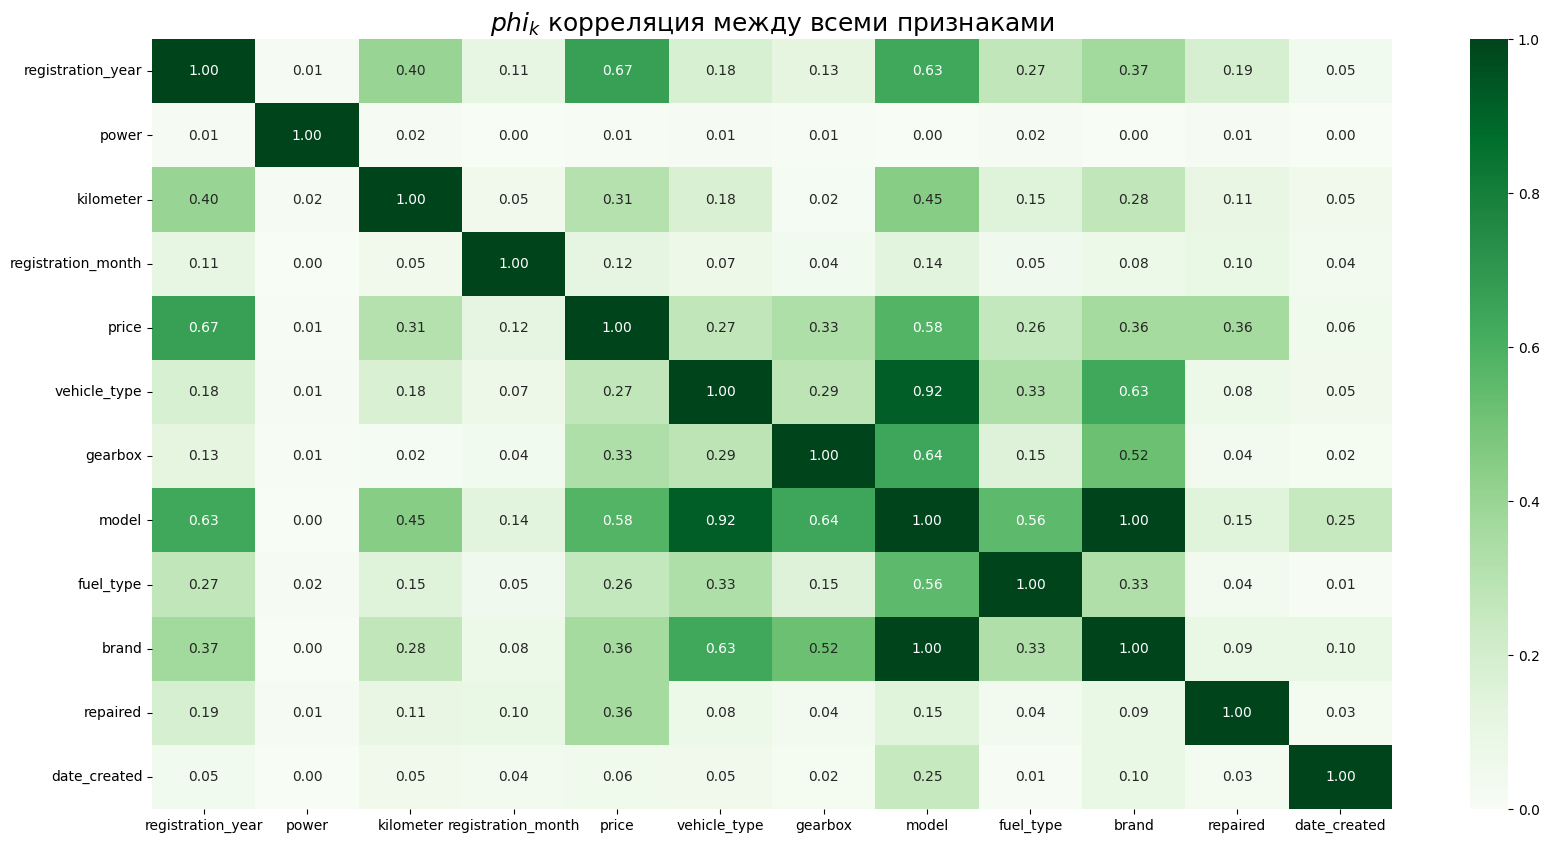

In [80]:
plt.figure(figsize=(20, 10))

interval_cols = num_cols + [target]
cols = interval_cols + cat_cols + ['date_created']
sns.heatmap(df[cols].phik_matrix(interval_cols=interval_cols),
            cmap='Greens',
            annot=True,
            fmt='.2f');

plt.title(r'$phi_k$ корреляция между всеми признаками', fontsize=18);

### 3.2. <a id='toc3_2_'></a>Мультиколлинеарность           [&#8593;](#toc0_)

In [81]:
scaler = StandardScaler()
df_for_vif = pd.DataFrame(scaler.fit_transform(df[interval_cols]), columns=interval_cols)

with_constants = add_constant(df_for_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = with_constants.columns
vif_data["VIF"] = [variance_inflation_factor(with_constants.values, i) for i in range(with_constants.shape[1])]

vif_data.sort_values(by='VIF')

,Variable,VIF
0,const,1.00
4,registration_month,1.01
2,power,1.03
3,kilometer,1.20
1,registration_year,1.35
5,price,1.48


### 3.3. <a id='toc3_3_'></a>Выводы по коллинеарности          [&#8593;](#toc0_)

Таргет имеет корреляцию:
- **выше среднего** (0.5 - 0.7): `registration_year` и `model`
- **среднюю** (0.3 - 0.5): `kilometer`, `gearbox`, `brand` и `repaired`
- **ниже среднего** (0.1 - 0.3): `registration_month`, `vehicle_type` и `fuel_type`
- **крайне низкую** (< 0.1): `power` и `date_created`

Мультиколлинеарность не наблюдается среди числовых признаков.

Также заметим, что признаки `brand` и `model` имеею крайне высокую корреляцию. Удалим (в пайплайне) признак `model` для ускорения обучения модели.

Несколько столбцов практически не имеют влияния на таргет. Поэтому отметим, что удалим их для ускорения работы модели.

In [82]:
target = 'price'

date_cols = [
    'date_created',
    'last_seen'
]

num_cols = [
    'registration_year',
    'power',
    'kilometer',
]

cat_cols = [
    'vehicle_type',
    'gearbox',
    'fuel_type',
    'brand',
    'repaired'
]

cols_to_drop = [
    'postal_code',
    'number_of_pictures',
    'model',
    'registration_month',
    'date_crawled'
]

## 4. <a id='toc4_'></a>Оптимизация памяти      [&#8593;](#toc0_)

Так как в данном проекте важна скорость, попробуем оптимизировать память, заменим типы данных на менее затратные в памяти.

In [83]:
df = optimize_memory_usage(df)

Размер использования памяти: до 38.49 Mb - после 27.17 Mb (29.4%)


## 5. <a id='toc5_'></a>Разделение данных             [&#8593;](#toc0_)

In [84]:
X = df.drop(columns=target)
y = df[target]

X.shape, y.shape

((296743, 15), (296743,))

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
display((X_train.shape, y_train.shape))
display((X_test.shape, y_test.shape))

((237394, 15), (237394,))

((59349, 15), (59349,))

## 6. <a id='toc6_'></a>Трансформеры и пайплайны           [&#8593;](#toc0_)

In [86]:
class FeatureDropperTransformer(BaseEstimator, TransformerMixin): 
    def __init__(self, cols_to_drop: list[str]):
        super().__init__()
        self.cols_to_drop = cols_to_drop

    def fit(self, X, y=None):
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return X.drop(columns=self.cols_to_drop, errors='ignore')

In [87]:
class MissingImputerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X['repaired'] = X['repaired'].fillna('unknown')
        X['gearbox'] = X['gearbox'].fillna('unknown')
        X['vehicle_type'] = X['vehicle_type'].fillna('other')
        X['fuel_type'] = X['fuel_type'].fillna('other')

        return X

In [88]:
class FuelTypeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X['fuel_type'] = X['fuel_type'].replace('petrol', 'gasoline')
        X['fuel_type'] = X['fuel_type'].apply(lambda x: x if x == 'gasoline' else 'other')

        return X

In [89]:
class DateExtracterTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        self.datetime_columns = X.select_dtypes(include=['datetime64[ns]']).columns
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        for col in self.datetime_columns:
            # Анализ важности показал, что эти признаки самые незначимые
            # X[f'{col}_year'] = X[col].dt.year
            X[f'{col}_month'] = X[col].dt.month

        return X.drop(columns=self.datetime_columns)

In [90]:
class MinMaxScalerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        self.scaler = MinMaxScaler()
        self.num_cols = None

    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes(include='number').columns
        self.scaler.fit(X[self.num_cols])
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_copy = X.copy()
        X_copy[self.num_cols] = self.scaler.transform(X_copy[self.num_cols])

        return X_copy

In [91]:
class OneHotEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols: list[str]):
        super().__init__()
        self.cat_cols = cat_cols
        self.ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='infrequent_if_exist', min_frequency=0.01)

    def fit(self, X, y=None):
        self.ohe.fit(X[self.cat_cols])
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        encoded = pd.DataFrame(self.ohe.transform(X[self.cat_cols]), index=X.index, columns=self.ohe.get_feature_names_out())
        return X.join(encoded).drop(columns=self.cat_cols)

In [92]:
class OrdinalEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols: list[str]):
        super().__init__()
        self.cat_cols = cat_cols
        self.encoder = OrdinalEncoder(min_frequency=0.01)

    def fit(self, X: pd.DataFrame, y=None):
        self.encoder.fit(X[self.cat_cols])
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_copy = X.copy()
        X_copy[self.cat_cols] = self.encoder.transform(X_copy[self.cat_cols])

        return X_copy

In [93]:
preprocessor_pipeline = Pipeline(
    [
        ('feature_dropper_transformer', FeatureDropperTransformer(cols_to_drop)),
        ('missing_imputer_transformer', MissingImputerTransformer()),
        ('fuel_type_transformer', FuelTypeTransformer()),
        ('date_extracter_transformer', DateExtracterTransformer())
    ]
)

## 7. <a id='toc7_'></a>Модели              [&#8593;](#toc0_)

In [94]:
def get_grid_search_results(pipeline: BaseEstimator,
                            model_name: str,
                            model_params_distribution: dict,
                            X_train: pd.DataFrame,
                            y_train: pd.Series,
                            ) -> tuple[float, float, float]:
    """Use grid search to find best params out of `model_params_distribution`.

    Returns:
        tuple[float, float, float]: 3 float numbers: mean fit time, mean predict time, mean RMSE on train
    """
    def format_time(seconds: float) -> str:
        if seconds < 0:
            raise ValueError('Invalid input: time cannot be negative')

        time_components = []
        hours = int(seconds // 3600)
        minutes = int(seconds % 3600 // 60)
        seconds = round(seconds % 60)

        if hours > 0:
            time_components.append(f'{hours}h')
        if hours > 0 or minutes > 0:
            time_components.append(f'{minutes}min')
        time_components.append(f'{seconds}sec')

        return ' '.join(time_components)


    grid = GridSearchCV(
        pipeline,
        model_params_distribution,
        scoring='neg_root_mean_squared_error',
        refit=True,
        n_jobs=-1,
        cv=3
    )

    # 1. Fit grid to find best params
    print(f'Start fitting grid for `{model_name}` model...', end='\t')
    grid.fit(X_train, y_train)
    print(colored('OK', 'green'))

    print(f'Best RMSE train score = {abs(grid.best_score_):.2f} with params:')
    print(grid.best_params_)

    best_estimator_res = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score').iloc[0]

    return (
       best_estimator_res['mean_fit_time'],
       best_estimator_res['mean_score_time'],
       abs(best_estimator_res['mean_test_score'])
    )

### 7.1. <a id='toc7_1_'></a>`KNeighborsRegressor`         [&#8593;](#toc0_)

In [95]:
knr_pipeline = Pipeline([
    ('preprocessing', preprocessor_pipeline),
    ('num_scaling', MinMaxScalerTransformer()),
    ('one_hot_encoder_transformer', OneHotEncoderTransformer(cat_cols)),
    ('model', KNeighborsRegressor(n_jobs=-1))
])

knr_params = {
    'num_scaling': [MinMaxScalerTransformer(), 'passthrough'],
    'model__n_neighbors': range(4, 9)
}

knr_res = get_grid_search_results(knr_pipeline, 'KNeighborsRegressor', knr_params, X_train, y_train)

Start fitting grid for `KNeighborsRegressor` model...	OK
Best RMSE train score = 1909.52 with params:
{'model__n_neighbors': 8, 'num_scaling': 'passthrough'}


### 7.2. <a id='toc7_2_'></a>`Ridge`         [&#8593;](#toc0_)

In [96]:
ridge_pipeline = Pipeline([
    ('preprocessing', preprocessor_pipeline),
    ('num_scaling', MinMaxScalerTransformer()),
    ('one_hot_encoder_transformer', OneHotEncoderTransformer(cat_cols)),
    ('model', Ridge(random_state=RANDOM_STATE))
])

ridge_params = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr'],
    'model__tol': [1e-4, 1e-3, 1e-2],
    'model__fit_intercept': [True, False],
}

ridge_res = get_grid_search_results(ridge_pipeline, 'Ridge', ridge_params, X_train, y_train)

Start fitting grid for `Ridge` model...	OK
Best RMSE train score = 3017.36 with params:
{'model__alpha': 1.0, 'model__fit_intercept': True, 'model__solver': 'auto', 'model__tol': 0.0001}


### 7.3. <a id='toc7_3_'></a>`LinearSVR`         [&#8593;](#toc0_)

In [97]:
svr_pipeline = Pipeline([
    ('preprocessing', preprocessor_pipeline),
    ('num_scaling', MinMaxScalerTransformer()),
    ('one_hot_encoder_transformer', OneHotEncoderTransformer(cat_cols)),
    ('model', LinearSVR(random_state=RANDOM_STATE))
])

svr_params = {
    'num_scaling': [MinMaxScalerTransformer(), 'passthrough'],
    'model__C': [0.01, 0.1, 1, 10, 100]
}

svr_res = get_grid_search_results(svr_pipeline, 'LinearSVR', svr_params, X_train, y_train)

Start fitting grid for `LinearSVR` model...	OK
Best RMSE train score = 3150.06 with params:
{'model__C': 100, 'num_scaling': MinMaxScalerTransformer()}


### 7.4. <a id='toc7_4_'></a>`RandomForestRegressor`         [&#8593;](#toc0_)

In [98]:
rfr_pipeline = Pipeline([
    ('preprocessing', preprocessor_pipeline),
    ('ordinal_encoder', OrdinalEncoderTransformer(cat_cols)),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

rfr_params = {
    'model__n_estimators': [100, 500, 1000],
    'model__min_samples_split': range(2, 5),
    'model__min_samples_leaf': range(2, 5)
}

rfr_res = get_grid_search_results(rfr_pipeline, 'RandomForestRegressor', rfr_params, X_train, y_train)

Start fitting grid for `RandomForestRegressor` model...	OK
Best RMSE train score = 1648.35 with params:
{'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 1000}


### 7.5. <a id='toc7_5_'></a>`CatBoostRegressor`         [&#8593;](#toc0_)

In [99]:
cbr_pipeline = Pipeline([
    ('preprocessing', preprocessor_pipeline),
    ('model', CatBoostRegressor(
        random_state=RANDOM_STATE,
        cat_features=cat_cols,
        boosting_type='Plain',
        leaf_estimation_iterations=1,
        thread_count=-1,
        silent=True)
    )
])

cbr_params = {
    'model__learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'model__depth': [4, 6, 8, 10],
    'model__iterations': [100, 250, 500, 1000]
}

cbr_res = get_grid_search_results(cbr_pipeline, 'CatBoostRegressor', cbr_params, X_train, y_train)

Start fitting grid for `CatBoostRegressor` model...	OK
Best RMSE train score = 1588.06 with params:
{'model__depth': 10, 'model__iterations': 1000, 'model__learning_rate': 0.1}


### 7.6. <a id='toc7_6_'></a>`LGBMRegressor`         [&#8593;](#toc0_)

In [100]:
class SetCategotyTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols):
        super().__init__()
        self.cat_cols = cat_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_copy = X.copy()
        X_copy[self.cat_cols] = X_copy[self.cat_cols].astype('category')

        return X_copy

In [101]:
lgbmr_pipeline = Pipeline([
    ('preprocessing', preprocessor_pipeline),
    ('set_category_type', SetCategotyTypeTransformer(cat_cols)),
    ('model', LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1))
])

lgbmr_params = {
    'model__learning_rate': [0.01, 0.05, 0.1, 0.3],
    'model__num_leaves': [20, 50, 100, 150],
    'model__max_depth': [3, 5, 7, 10, 15]
}

lgbmr_res = get_grid_search_results(lgbmr_pipeline, 'LGBMRegressor', lgbmr_params, X_train, y_train)

Start fitting grid for `LGBMRegressor` model...	OK
Best RMSE train score = 1598.43 with params:
{'model__learning_rate': 0.3, 'model__max_depth': 15, 'model__num_leaves': 150}


### 7.7. <a id='toc7_7_'></a>Результаты         [&#8593;](#toc0_)

In [102]:
pd.DataFrame(
    data=[knr_res, ridge_res, svr_res, rfr_res, cbr_res, lgbmr_res],
    index=['KNeighborsRegressor', 'Ridge', 'LinearSVR', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor'],
    columns=['mean_fit_time', 'mean_predict_time', 'mean_train_rmse']
).sort_values('mean_train_rmse')

,mean_fit_time,mean_predict_time,mean_train_rmse
CatBoostRegressor,769.72,1.89,1588.06
LGBMRegressor,4.32,0.30,1598.43
RandomForestRegressor,630.64,47.13,1648.35
KNeighborsRegressor,1.79,88.60,1909.52
Ridge,1.97,0.36,3017.36
LinearSVR,2.64,0.38,3150.06


В результате 2 модели из 6 не проходит по по целевой метрике (RMSE < 2500). Среди оставшихся 4 лучшего всего (по метрике) себя показал `CatBoostRegressor`. Однако разница по метрике между ним и `LGBMRegressor` крайне незначительна. При этом `LGBMRegressor` значительно быстрее обучается (практически в 10 раз) и более чем в 3 раза быстрее предсказывает. Поэтому для дальнейшей работы заказчику рекомендуется именно эта модель с параметрами `{'model__learning_rate': 0.3, 'model__max_depth': 15, 'model__num_leaves': 150}`.

### 7.8. <a id='toc7_8_'></a>Метрика на тестовом датасете [&#8593;](#toc0_)

In [103]:
best_estimator_pipeline = Pipeline([
    ('preprocessing', preprocessor_pipeline),
    ('set_category_type', SetCategotyTypeTransformer(cat_cols)),
    ('model', LGBMRegressor(random_state=RANDOM_STATE,
                            n_jobs=-1,
                            verbosity=-1,
                            learning_rate=0.3,
                            max_depth=15,
                            num_leaves=150)
    )
])

best_estimator_pipeline.fit(X_train, y_train);

In [104]:
y_pred = best_estimator_pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
round(rmse, 2)

1560.63

Метрика на тестовом датасете более чем подходит под условие (RMSE < 2500).

## 8. <a id='toc8_'></a>Важность признаков      [&#8593;](#toc0_)

In [105]:
best_estimator_pipeline_without_model = Pipeline([
    ('preprocessing', preprocessor_pipeline),
    ('set_category_type', SetCategotyTypeTransformer(cat_cols))
])

best_estimator_pipeline_without_model.fit(X_test);

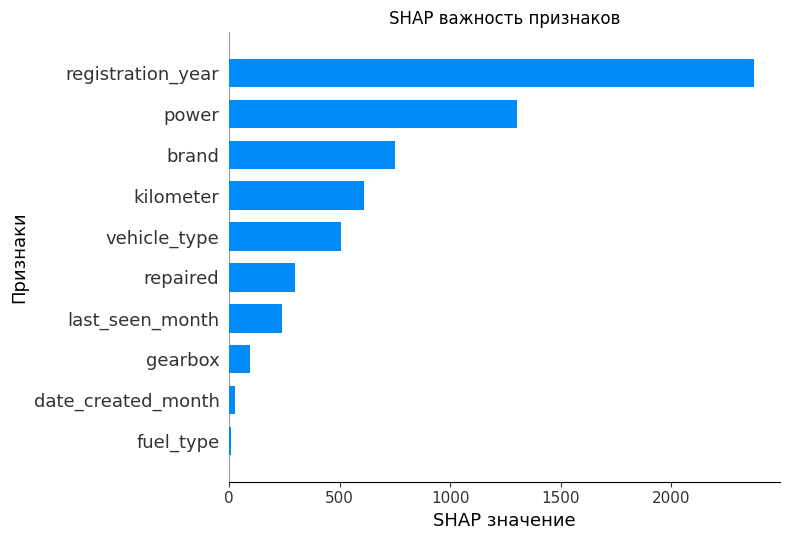

In [106]:
X_test_processed = best_estimator_pipeline_without_model.transform(X_test)
best_model = best_estimator_pipeline.named_steps['model']

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_processed)

shap.summary_plot(shap_values, X_test_processed, color_bar_label='Признаки', show=False, plot_type='bar', show_values_in_legend=True, max_display=100)
plt.title('SHAP важность признаков')
plt.xlabel('SHAP значение')
plt.ylabel('Признаки', fontsize=13)

plt.tight_layout()
plt.show()

## 9. <a id='toc9_'></a>Финальный вывод         [&#8593;](#toc0_)

В рамках данного проекта мы работали с датасетом о различных автомобилях. Целевым признаком является столбец `price`, который отражает цену авто в евро. В качестве входных признаков дана информация об автомобиле, например, год регистрации, бренд и модель, пробег и так далее. Также есть некая информация о анкете: дата создания анкеты, дата выгрузки анкеты из базы и дата последней активности пользователя.

<h3>Предоработка и исследования</h3>

В рамках первичной обработки были удалены полные дубликаты. Также в 5 столбцах обнаружены пропуски. Все пропуски находятся в категориальных признаках и будут заполнены специальными категориями `unknown` и объединены с категорией `other`.

Были обнаружены, некоторые аномалии. Например, столбец `registration_month` имеет 13 уникальных значений (от 0 до 12 включительно). Однако было принято решение оставить как есть, так как значение 0, скорее всего, несет в себе некую информацию.

В рамках EDA были выявлены некоторые неинформативные признаки, которые были сразу удалены. Также были удалены записи, которые содержат аномалии, а именно:

- невозможный или неактуальный для нашей модели год регистрации
- нулевую цену
- нулевую мощность авто

<h3>Корреляция</h3>

Была исследована корреляция между признаки. Результаты следующие:  
Таргет имеет корреляцию:
- **выше среднего** (0.5 - 0.7): `registration_year` и `model`
- **среднюю** (0.3 - 0.5): `kilometer`, `gearbox`, `brand` и `repaired`
- **ниже среднего** (0.1 - 0.3): `registration_month`, `vehicle_type` и `fuel_type`
- **крайне низкую** (< 0.1): `power` и `date_created`

Мультиколлинеарность не наблюдается среди числовых признаков.

На данном этапе было принято решение удалить признаки, которые практички не имеют влияния на таргет (`registraion_month`, `date_crawled`), а также признак `model` так как он имеет крайне высокую корреляцию с признаком `brand`.

<h3>Пайплайны и модели</h3>

С помощью написанных трансформеров был создан пайплайн по предобработке данных, включающий в себя несколько шагов, таких как:
- заполнение пропусков
- извлечение компонентов из дат
- кодирование категориальных признаков

Было протестировано 6 различных моделей. В результате 2 из них не проходят по по целевой метрике (RMSE < 2500). Среди оставшихся 4 лучшего всего (по метрике) себя показал `CatBoostRegressor`. Однако разница по метрике между ним и `LGBMRegressor` крайне незначительна. При этом `LGBMRegressor` значительно быстрее обучается (практически в 10 раз) и более чем в 3 раза быстрее предсказывает. Поэтому для дальнейшей работы заказчику рекомендуется именно эта модель с параметрами `{'model__learning_rate': 0.3, 'model__max_depth': 15, 'model__num_leaves': 150}`.

Для данной модели метрика на тестовой выборке составила `1560`, что подходит под условия проекта.